In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Monet Style Image Generation with GAN

## Problem Statement
This project is to use GAN to generate Claude Monet style paintings from real photography. GANs operate through an adversarial learning process, where a generator creates images while a discriminator evaluates their authenticity—iteratively improving both models. Unlike traditional GANs that generate images from random noise, this Kaggle competition focuses on domain-to-domain image translation (real-world photos to Monet-style paintings). To achieve this, we require a specialized GAN architecture, such as Conditional GAN or CycleGAN. Since CycleGAN is designed for unpaired image-to-image translation, it perfectly suits our use case, eliminating the need for aligned real-Monet image pairs.
We will train on two datasets:
- Real-life photos (7038 samples)
- Monet-style paintings (300 samples)
Each image is 256x256 pixels with RGB channels, which means we must account for potential dataset imbalance affecting training dynamics.

For evaluation, we rely on MiFID scores, which measure reality within a single domain. However, this metric does not assess how well our transformed images mimic both artistic and photographic styles. Thus, we will further evaluate model convergence using loss metrics and qualitative analysis of generated images.


## Import Modules


In [27]:
import time
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONWARNINGS']='ignore'
import warnings
warnings.filterwarnings("ignore")

import logging
import tensorflow as tf
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

## EDA

In this step, we perform EDA meaning we understand the data before building CycleGAN model
- Checking dataset
- Investigating dataset imbalance
- Visualizing image differences


In [28]:
#Image visualization from directory
def visualize_images_from_directory(directory, n_images=5):
    images = os.listdir(directory)
    sample_images = np.random.choice(images, n_images, replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)
        
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        # plt.title(img_name)
    
    plt.tight_layout()
    plt.show()

#Image property & Pixel distribution analysis
def analyze_image_properties(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    
    print(f"Image size: {img.size} (width x height)")
    print(f"Image mode: {img.mode}")
    print(f"Array shape: {img_array.shape}")
    
    # display image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    plt.show()
    
    # pixel intensity histogram
    if img_array.ndim == 2 or img_array.shape[2] == 1:
        plt.hist(img_array.ravel(), bins=50, color='gray')
        plt.title("Pixel Intensity Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.show()
    else:
        colors = ['red', 'green', 'blue']
        for i, color in enumerate(colors):
            plt.hist(img_array[:, :, i].ravel(), bins=50, color=color, alpha=0.5, label=f'{color} channel')
        plt.title("Pixel Intensity Distribution")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()


In [29]:
#Extracts the filename from a given path
def clean_path(file):
    return os.path.basename(file)

#Removes the file extension
def clean_ext(file):
    return file[:-4]

In [30]:
# Include basic data augmentation - Preprocessing image
def preprocess_image(file_path, augment=False):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_crop(image, size=[256, 256, 3])
    else:
        image = tf.image.resize(image, [256, 256])
    
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Preprocessing dataset
def preprocess_dataset(file_paths, batch_size=4, shuffle=False, repeat=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths))
    
    dataset = dataset.map(lambda x: preprocess_image(x, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    if repeat:
        dataset = dataset.repeat()
    
    return dataset

In [31]:
from pathlib import Path
import pandas as pd

# Define the directory
monet_dir = Path('/kaggle/input/gan-getting-started/monet_jpg/')

# List all .jpg files
monet_files = list(monet_dir.glob('*.jpg'))

# Create the DataFrame
monet_df = pd.DataFrame({
    'file_w_ext': [f.name for f in monet_files],
    'file': [f.stem for f in monet_files],  # stem = filename without extension
    'full_path': [str(f) for f in monet_files],
    'label': 1
})

monet_df.head()

file_w_ext        file  \
0  f4413e97bd.jpg  f4413e97bd   
1  7341d96c1d.jpg  7341d96c1d   
2  de6f71b00f.jpg  de6f71b00f   
3  99d94af5dd.jpg  99d94af5dd   
4  99a51d3e25.jpg  99a51d3e25   

                                           full_path  label  
0  /kaggle/input/gan-getting-started/monet_jpg/f4...      1  
1  /kaggle/input/gan-getting-started/monet_jpg/73...      1  
2  /kaggle/input/gan-getting-started/monet_jpg/de...      1  
3  /kaggle/input/gan-getting-started/monet_jpg/99...      1  
4  /kaggle/input/gan-getting-started/monet_jpg/99...      1

In [32]:
from pathlib import Path
import pandas as pd

# Define the photo directory
photo_dir = Path('/kaggle/input/gan-getting-started/photo_jpg/')

# Get all .jpg file paths
photo_files = list(photo_dir.glob('*.jpg'))

# Build the DataFrame
photo_df = pd.DataFrame({
    'file_w_ext': [f.name for f in photo_files],  # filename with extension
    'file': [f.stem for f in photo_files],        # filename without extension
    'full_path': [str(f) for f in photo_files],   # full file path
    'label': 0                                     # label = 0 for photos (typically)
})

photo_df.head()


file_w_ext        file  \
0  fb97febc5f.jpg  fb97febc5f   
1  c54c5368af.jpg  c54c5368af   
2  4a06596662.jpg  4a06596662   
3  2629524a69.jpg  2629524a69   
4  5e64b64de8.jpg  5e64b64de8   

                                           full_path  label  
0  /kaggle/input/gan-getting-started/photo_jpg/fb...      0  
1  /kaggle/input/gan-getting-started/photo_jpg/c5...      0  
2  /kaggle/input/gan-getting-started/photo_jpg/4a...      0  
3  /kaggle/input/gan-getting-started/photo_jpg/26...      0  
4  /kaggle/input/gan-getting-started/photo_jpg/5e...      0

In [33]:
#paths to datasets
from pathlib import Path
photo_dir = Path('/kaggle/input/gan-getting-started/photo_jpg/')
photo_files = list(photo_dir.glob('*.jpg'))

# --- Get image paths for photo and Monet datasets ---
photo_paths = [os.path.join(photo_dir, fname) for fname in os.listdir(photo_dir) if os.path.splitext(fname)[1].lower() == '.jpg']
monet_paths = [os.path.join(monet_dir, fname) for fname in os.listdir(monet_dir) if os.path.splitext(fname)[1].lower() == '.jpg']

# --- Create datasets ---
photo_dataset = preprocess_dataset(photo_paths, batch_size=4, shuffle=True)
monet_dataset = preprocess_dataset(monet_paths, batch_size=4, repeat=True)

Image size: (256, 256) (width x height)
Image mode: RGB
Array shape: (256, 256, 3)


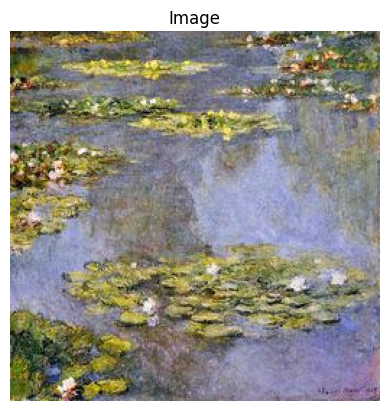

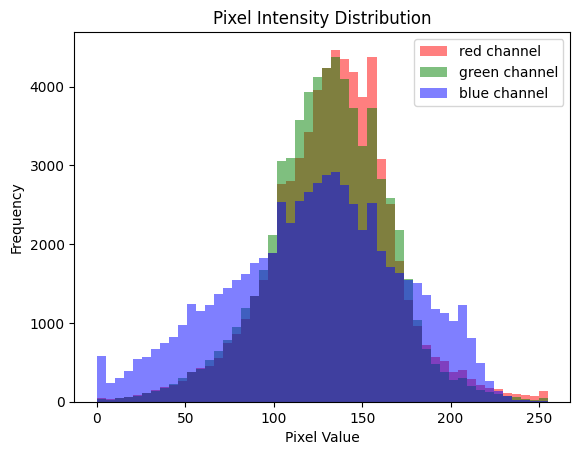

In [34]:
#Image Properties for a Sample Monet Painting
monet_image_path = monet_paths[0]  
analyze_image_properties(monet_image_path)

Image size: (256, 256) (width x height)
Image mode: RGB
Array shape: (256, 256, 3)


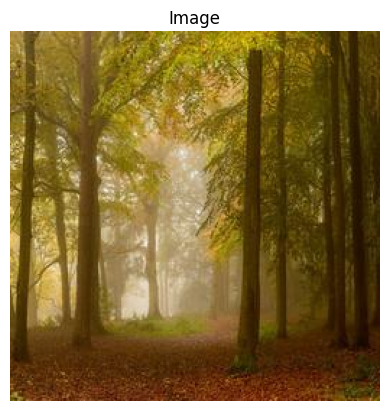

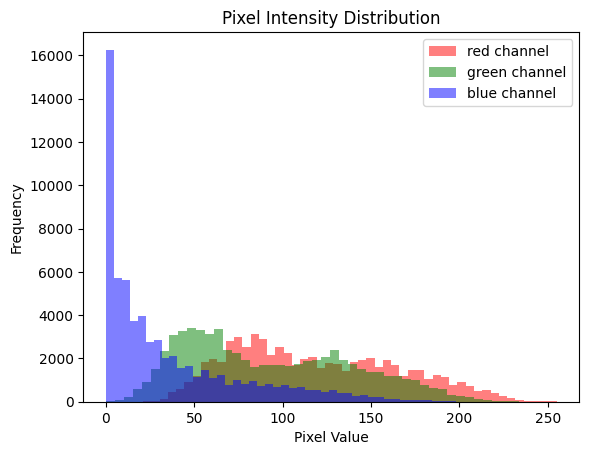

In [35]:
#Image Properties for a Sample Photo Painting

photo_image_path = photo_paths[0] 
analyze_image_properties(photo_image_path)

## Data Description

This project uses two distinct datasets: real-world photos and Monet-style paintings, both formatted as 256x256 RGB images.
- Real Photos (7038 images) : Standard digital photographs capturing landscapes, objects, and scenes.
- Monet Paintings (300 images) : Artistic images in the style of Claude Monet, with expressive brushstrokes and vibrant colors.

Since there are far more real photos than Monet paintings, this data imbalance could affect model training. The goal is to transform real images into Monet-style paintings while maintaining clarity and artistic integrity.


In [36]:
monet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_w_ext  300 non-null    object
 1   file        300 non-null    object
 2   full_path   300 non-null    object
 3   label       300 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 9.5+ KB


In [37]:
photo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7038 entries, 0 to 7037
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_w_ext  7038 non-null   object
 1   file        7038 non-null   object
 2   full_path   7038 non-null   object
 3   label       7038 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 220.1+ KB


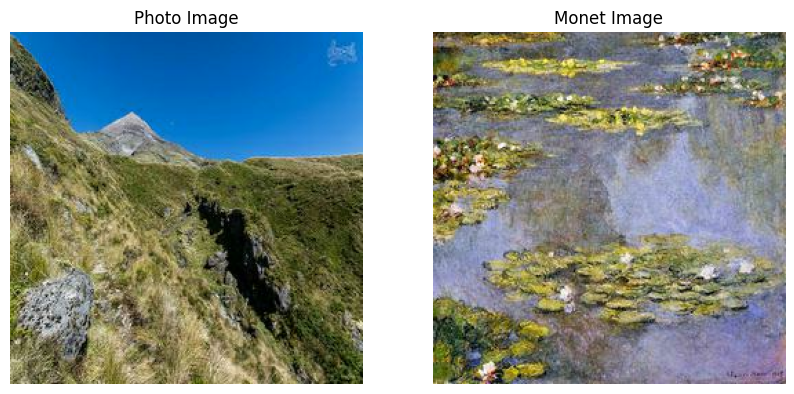

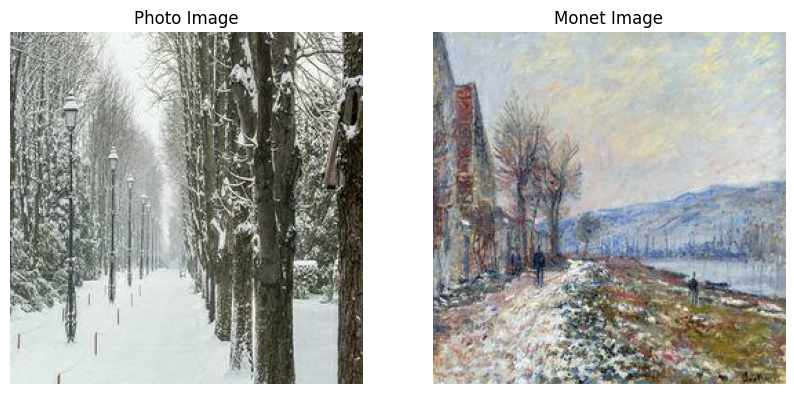

In [38]:

# Get image paths for photo and Monet datasets 
photo_paths = [os.path.join(photo_dir, fname) for fname in os.listdir(photo_dir) if os.path.splitext(fname)[1].lower() == '.jpg']
monet_paths = [os.path.join(monet_dir, fname) for fname in os.listdir(monet_dir) if os.path.splitext(fname)[1].lower() == '.jpg']

# Create datasets
photo_dataset = preprocess_dataset(photo_paths, batch_size=4, shuffle=True)
monet_dataset = preprocess_dataset(monet_paths, batch_size=4, repeat=True)

# Zip into paired dataset for training 
combined_dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset))

# Confirm the batches have been processed correctly
for photo_batch, monet_batch in combined_dataset.take(2):
    # select the first image from each batch
    photo_image = photo_batch[0].numpy()
    monet_image = monet_batch[0].numpy()

    # visualize real and Monet images
    plt.figure(figsize=(10, 5))

    # display real image
    plt.subplot(1, 2, 1)
    plt.title("Photo Image")
    plt.imshow(photo_image)
    plt.axis("off")

    # display the Monet image
    plt.subplot(1, 2, 2)
    plt.title("Monet Image")
    plt.imshow(monet_image)
    plt.axis("off")

    plt.show()


In [39]:
#Dataset Size Verification - Ensuring Combined Dataset Matches Photo Dataset
print(f"Confirm |combined dataset| = |photo dataset|:\n\
photo_dataset: {len(photo_dataset)}\n\
combined_dataset: {len(combined_dataset)}")

Confirm |combined dataset| = |photo dataset|:
photo_dataset: 1760
combined_dataset: 1760


## EDA Conclusion
In this project, we first prepared our images by loading and normalizing them between 0 and 1 to make sure they were ready for training. Since training a GAN is computationally demanding, we decided not to add extra image augmentation to keep things efficient.
We then organized the images into batches of 4 to speed up training. Since the Monet dataset is much smaller than the real-photo dataset, we repeated Monet images to balance the data.

## Model Building: CycleGAN
A regular GAN creates images from random noise, but this project requires transforming real photos into Monet-style paintings—which is why we use CycleGAN.
CycleGAN works with two image domains (real photos & Monet paintings) and includes:
- Two generators (one to convert real photos into Monet paintings, and one to do the reverse).
- Two discriminators (one for real photos, one for Monet paintings).
  
Instead of just checking if images look real, CycleGAN adds two special losses to make transformations more accurate:
- Cycle Loss → Makes sure converting an image to Monet and back doesn’t change it too much.
- Identity Loss → Prevents unnecessary changes when an image is already in the correct style.
With these extra constraints, CycleGAN becomes better at transforming images smoothly between real and Monet styles. We'll implement this architecture and train it using Kaggle’s dataset.

In [40]:
LAMBDA_TERM = 10
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#Discriminator Loss (disc_loss)
def disc_loss(real_output, gen_output):
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    gen_loss = bce_loss(tf.zeros_like(gen_output), gen_output)
    return 0.5 * (real_loss + gen_loss)

#Generator Loss (gen_loss)
def gen_loss(gen_output):
    return bce_loss(tf.ones_like(gen_output), gen_output)

#Cycle Consistency Loss (cycle_loss)
def cycle_loss(original_image, transformed_image):
    return LAMBDA_TERM * tf.reduce_mean(tf.abs(original_image - transformed_image))

#Identity Loss (identity_loss)
def identity_loss(original_image, same_image):
    return 0.5 * LAMBDA_TERM * tf.reduce_mean(tf.abs(original_image - same_image))

In [41]:
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y):
        super().__init__()
        self.gen_g = generator_g  # X -> Y
        self.gen_f = generator_f  # Y -> X
        self.disc_x = discriminator_x  # Discriminator for domain X
        self.disc_y = discriminator_y  # Discriminator for domain Y

    def compile(self, opt_g, opt_f, opt_dx, opt_dy, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super().compile()
        self.opt_g = opt_g
        self.opt_f = opt_f
        self.opt_dx = opt_dx
        self.opt_dy = opt_dy

        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Generator forward pass
            fake_y = self.gen_g(real_x, training=True)
            cycled_x = self.gen_f(fake_y, training=True)

            fake_x = self.gen_f(real_y, training=True)
            cycled_y = self.gen_g(fake_x, training=True)

            same_x = self.gen_f(real_x, training=True)
            same_y = self.gen_g(real_y, training=True)

            # Discriminator outputs
            disc_real_x = self.disc_x(real_x, training=True)
            disc_fake_x = self.disc_x(fake_x, training=True)

            disc_real_y = self.disc_y(real_y, training=True)
            disc_fake_y = self.disc_y(fake_y, training=True)

            # Generator losses
            gen_g_loss = self.gen_loss_fn(disc_fake_y)
            gen_f_loss = self.gen_loss_fn(disc_fake_x)

            total_cycle_loss = self.cycle_loss_fn(real_x, cycled_x) + self.cycle_loss_fn(real_y, cycled_y)

            total_gen_g_loss = gen_g_loss + total_cycle_loss + self.identity_loss_fn(real_y, same_y)
            total_gen_f_loss = gen_f_loss + total_cycle_loss + self.identity_loss_fn(real_x, same_x)

            # Discriminator losses
            disc_x_loss = self.disc_loss_fn(disc_real_x, disc_fake_x)
            disc_y_loss = self.disc_loss_fn(disc_real_y, disc_fake_y)

        # Apply gradients
        self._apply_gradients(self.opt_g, tape, total_gen_g_loss, self.gen_g)
        self._apply_gradients(self.opt_f, tape, total_gen_f_loss, self.gen_f)
        self._apply_gradients(self.opt_dx, tape, disc_x_loss, self.disc_x)
        self._apply_gradients(self.opt_dy, tape, disc_y_loss, self.disc_y)

        return {
            "gen_g_loss": total_gen_g_loss,
            "gen_f_loss": total_gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss,
        }

    def _apply_gradients(self, optimizer, tape, loss, model):
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))


In [42]:
# Generator
def unet_generator(output_channels, norm_type='instancenorm'):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

#Discriminator
def discriminator(norm_type='instancenorm', target=False):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)


In [43]:
# 1. function to build the components
def build_cycle_gan_models(output_channels=3, norm_type='instancenorm'):
    generator_g = unet_generator(output_channels, norm_type=norm_type)  # X -> Y
    generator_f = unet_generator(output_channels, norm_type=norm_type)  # Y -> X

    discriminator_x = discriminator(norm_type=norm_type, target=False)  # for domain X
    discriminator_y = discriminator(norm_type=norm_type, target=False)  # for domain Y

    return generator_g, generator_f, discriminator_x, discriminator_y

# 2. Instantiate models
generator_g, generator_f, discriminator_x, discriminator_y = build_cycle_gan_models()

# 3. Create CycleGAN model instance
model = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)

# 4. Define optimizers and loss functions
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# 5. Compile the model
model.compile(
    opt_g=generator_g_optimizer,
    opt_f=generator_f_optimizer,
    opt_dx=discriminator_x_optimizer,
    opt_dy=discriminator_y_optimizer,
    gen_loss_fn=gen_loss,
    disc_loss_fn=disc_loss,
    cycle_loss_fn=cycle_loss,
    identity_loss_fn=identity_loss
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_cb = EarlyStopping(
    monitor='gen_g_loss',
    patience=3,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    filepath='best_cyclegan_model.weights.h5', 
    monitor='gen_g_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# 6. Train the model
history = model.fit(
    combined_dataset,
    epochs=10,
    callbacks=[early_stopping_cb, checkpoint_cb]
)


Epoch 1/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - disc_x_loss: 0.6586 - disc_y_loss: 0.6572 - gen_f_loss: 2.4844 - gen_g_loss: 2.5135
Epoch 1: gen_g_loss improved from inf to 2.18847, saving model to best_cyclegan_model.weights.h5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 53s 26ms/step - disc_x_loss: 0.6586 - disc_y_loss: 0.6572 - gen_f_loss: 2.4841 - gen_g_loss: 2.5133
Epoch 2/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - disc_x_loss: 0.6496 - disc_y_loss: 0.6484 - gen_f_loss: 1.7172 - gen_g_loss: 1.7535
Epoch 2: gen_g_loss improved from 2.18847 to 1.76259, saving model to best_cyclegan_model.weights.h5
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - disc_x_loss: 0.6496 - disc_y_loss: 0.6483 - gen_f_loss: 1.7172 - gen_g_loss: 1.7535
Epoch 3/10
1759/1760 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - disc_x_loss: 0.6451 - disc_y_loss: 0.6493 - gen_f_loss: 1.5029 - gen_g_loss: 1.5284
Epoch 3: gen_g_loss improved from 1.76259 to 1.71231, saving model to best_cyclegan_model.weights.h5
1760/1760 ━━━━━━

In [44]:
model.summary()

Model: "cycle_gan_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_4 (Functional)            │ (None, 256, 256, 3)         │           6,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_5 (Functional)            │ (None, 256, 256, 3)         │           6,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_6 (Functional)            │ (None, 128, 128, 1)         │           4,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_7 (Functional)            │ (None, 128, 128, 1)         │           4,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,744 (81.03 KB)

 Trainable params: 20,744 (81.03 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# # Save weights for generator_g
# generator_g.save_weights('/kaggle/working/models/generator_g.weights.h5')

# # Save weights for generator_f
# generator_f.save_weights('/kaggle/working/models/generator_f.weights.h5')

# # Save weights for discriminator_x
# discriminator_x.save_weights('/kaggle/working/models/discriminator_x.weights.h5')

# # Save weights for discriminator_y
# discriminator_y.save_weights('/kaggle/working/models/discriminator_y.weights.h5')

# # Save the entire model (architecture + weights)
# model.save('/kaggle/working/cyclegan_model.keras')

In [46]:
# Function to generate Monet images in smaller batches
def generate_images_in_batches(photo_paths, batch_size=32):
    fake_monet_images = []
    
    # Process images in smaller batches
    for i in range(0, len(photo_paths), batch_size):
        batch_paths = photo_paths[i:i+batch_size]
        
        # Load and preprocess the batch of images
        batch_images = tf.stack([preprocess_image(p) for p in batch_paths])
        
        # Generate Monet images by passing the test images through the generator
        fake_batch = model.gen_g(batch_images, training=False)
        
        # Rescale the generated images and store them
        fake_batch = ((fake_batch + 1.0) * 127.5).numpy().astype(np.uint8)
        fake_monet_images.extend(fake_batch)
    
    return fake_monet_images

# Call the function with the appropriate batch size
fake_monet_images = generate_images_in_batches(photo_paths, batch_size=32)


In [47]:
# # Create a directory to save generated images
# output_dir = '/kaggle/working/monet_generated_images'
# os.makedirs(output_dir, exist_ok=True)

# # Save each generated Monet image
# for i, img_array in enumerate(fake_monet_images):
#     img = Image.fromarray(img_array)
#     img_name = os.path.basename(photo_paths[i])
#     img.save(os.path.join(output_dir, img_name))


In [48]:
# # Create a DataFrame for submission with the image names
# import pandas as pd

# submission_df = pd.DataFrame({
#     'image_name': [os.path.basename(p) for p in photo_paths]
# })

# # Save the DataFrame as a CSV file (this is usually required for Kaggle submission)
# submission_df.to_csv('/kaggle/working/submission_1.csv', index=False)

# print("Monet-style images and submission file saved in /kaggle/working/")


In [49]:
# # reLoad the entire model in future
# loaded_model = tf.keras.models.load_model('/kaggle/working/cyclegan_model')

# # Load the model weights (if only the weights were saved)
# model.load_weights('/kaggle/working/cyclegan_weights.h5')


In [50]:
# generator.summary()

In [51]:
# Plotting function
def plot_metrics(hist, name):
    gen_g_loss = hist.history['gen_g_loss']
    gen_f_loss = hist.history['gen_f_loss']
    disc_x_loss = hist.history['disc_x_loss']
    disc_y_loss = hist.history['disc_y_loss']

    plt.figure(figsize=(11, 7))

    plt.plot(gen_g_loss, marker='o', label='Generator G loss (photo→Monet)')
    plt.plot(gen_f_loss, marker='o', label='Generator F loss (Monet→photo)')
    plt.plot(disc_x_loss, marker='o', label='Discriminator X loss (photo)')
    plt.plot(disc_y_loss, marker='o', label='Discriminator Y loss (Monet)')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(name)
    plt.legend()
    plt.grid(True)
    plt.show()


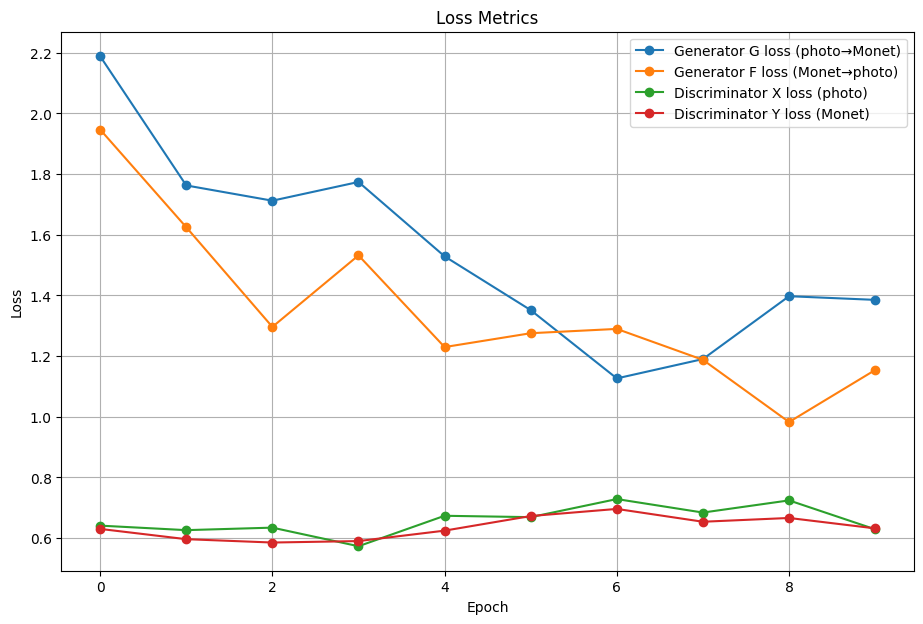

In [52]:
plot_metrics(history, "Loss Metrics")

In [53]:
# load and preprocess the input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# post-process the generated image
def postprocess_image(image_array):
    image_array = np.squeeze(image_array, axis=0)
    image_array = (image_array * 255).astype(np.uint8)
    return image_array

# predict a stylized image
def predict_image(image_path, _generator):
    input_image = preprocess_image(image_path)
    generated_image = _generator(input_image)
    return postprocess_image(generated_image)

# visualize the input and output
def visualize_predictions(image_dir, _generator, num_images=10):
    # get all image paths from the directory
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if os.path.splitext(fname)[1] == '.jpg']
    
    # randomly sample 10 images
    random_paths = random.sample(image_paths, num_images)
    
    # visualize predictions
    plt.figure(figsize=(15, num_images * 2.5))
    for i, image_path in enumerate(random_paths):
        # predict the stylized image
        generated_image = predict_image(image_path, _generator)
        # generated_image = np.expand_dims(generated_image, axis=0)
        # print(generated_image)
        
        # load the input image for visualization
        input_image = load_img(image_path, target_size=(256, 256))

        # display the input image
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.title(f"Input Image {i + 1}")
        plt.imshow(input_image)
        plt.axis("off")

        # display the stylized image
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.title(f"Stylized Image {i + 1}")
        plt.imshow(generated_image)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

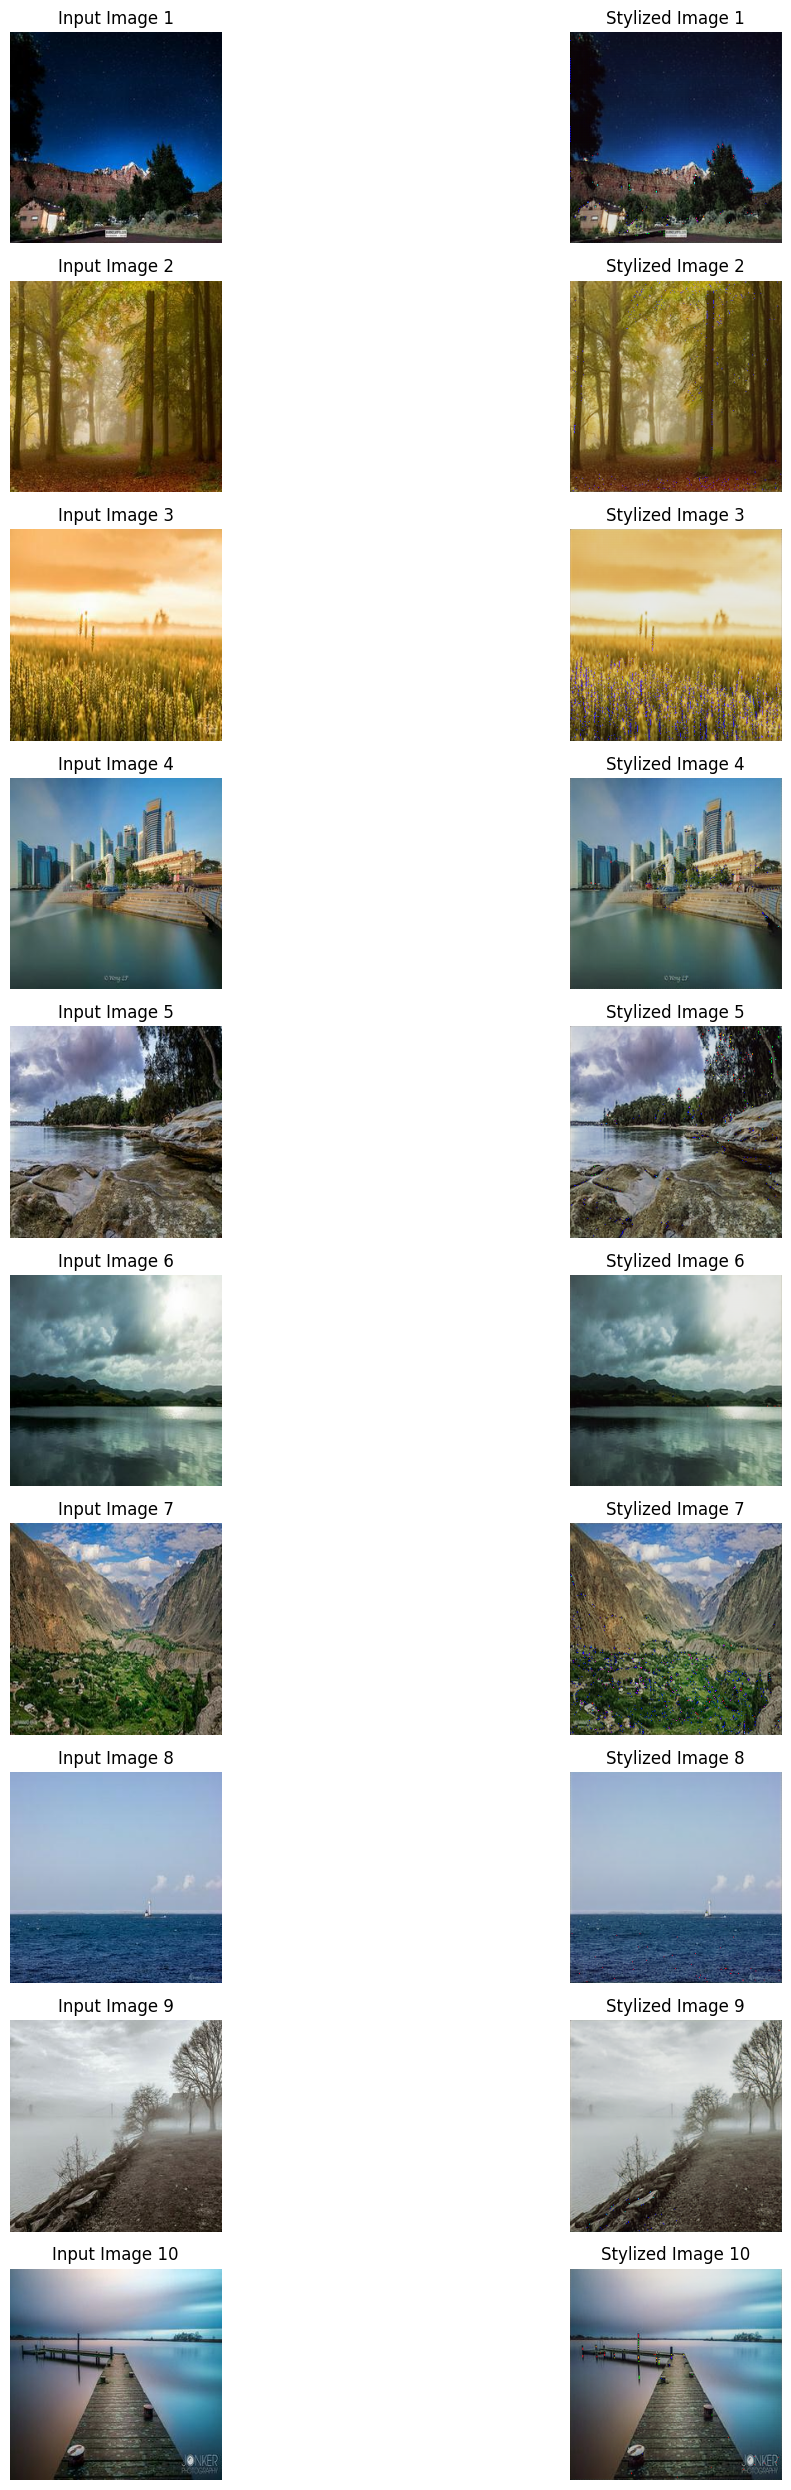

In [54]:
#Visualize Predictions
visualize_predictions("/kaggle/input/gan-getting-started/photo_jpg/", generator_g)

In [55]:
print('gen_monet_loss \n', history.history['gen_g_loss'])  # Generator G (Photo → Monet)
print('gen_real_loss \n', history.history['gen_f_loss'])  # Generator F (Monet → Photo)
print('disc_monet_loss \n', history.history['disc_x_loss'])  # Discriminator X (Photos)
print('disc_real_loss \n', history.history['disc_y_loss'])  # Discriminator Y (Monets)

gen_monet_loss 
 [2.188469886779785, 1.7625917196273804, 1.712306022644043, 1.77400803565979, 1.5288840532302856, 1.3516051769256592, 1.126591444015503, 1.1903425455093384, 1.397497534751892, 1.3854289054870605]
gen_real_loss 
 [1.9468193054199219, 1.6248270273208618, 1.2963390350341797, 1.5320762395858765, 1.229866623878479, 1.2755423784255981, 1.2897119522094727, 1.1877729892730713, 0.982779324054718, 1.154295563697815]
disc_monet_loss 
 [0.6413463354110718, 0.6264872550964355, 0.6347335577011108, 0.5734815001487732, 0.6738258600234985, 0.6693013906478882, 0.7288957834243774, 0.6844311356544495, 0.7245376706123352, 0.6292515397071838]
disc_real_loss 
 [0.6305198669433594, 0.5966968536376953, 0.5856515765190125, 0.5904546976089478, 0.6248270273208618, 0.6729950904846191, 0.6964017748832703, 0.6541396379470825, 0.6666120290756226, 0.6322786211967468]


## Hyperparameter Tuning
We noticed that the Monet generator is not performing well, likely because we have way more real photos than Monet paintings in our dataset. This means the model is learning too much from real photos and struggling to recreate Monet-style images correctly.
To fix this, we will adjust key settings (hyperparameters) to improve results. This includes:
- Changing the learning rate to help the model learn at the right speed.
- Adjusting cycle consistency loss to make sure converted images stay realistic.
- Tweaking batch sizes to stabilize training.
- Adding more Monet-like images (through augmentation) to balance the dataset.

By fine-tuning these settings, we aim to help the Monet generator produce clearer, more artistic images and improve overall model performance

In [56]:
OUTPUT_CHANNELS=3

# instantiate unet generators and discriminators
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)


In [57]:
# instantiate model
model = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)

In [58]:
model.summary()

Model: "cycle_gan_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_8 (Functional)            │ (None, 256, 256, 3)         │           6,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_9 (Functional)            │ (None, 256, 256, 3)         │           6,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_10 (Functional)           │ (None, 128, 128, 1)         │           4,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_11 (Functional)           │ (None, 128, 128, 1)         │           4,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,744 (81.03 KB)

 Trainable params: 20,744 (81.03 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.compile(
    opt_g=tf.keras.optimizers.Adam(2e-2, beta_1=0.5),   # For generator G
    opt_f=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),   # For generator F
    opt_dx=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),  # For discriminator X
    opt_dy=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),  # For discriminator Y
    gen_loss_fn=gen_loss,
    disc_loss_fn=disc_loss,
    cycle_loss_fn=cycle_loss,
    identity_loss_fn=identity_loss
)

In [60]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='gen_g_loss',  
    patience=3,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

history = model.fit(combined_dataset, epochs=10, callbacks=[early_stopping])


Epoch 1/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 54s 26ms/step - disc_x_loss: 0.6111 - disc_y_loss: 0.3684 - gen_f_loss: 7.7034 - gen_g_loss: 9.7993
Epoch 2/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - disc_x_loss: 0.5556 - disc_y_loss: 0.0883 - gen_f_loss: 8.7082 - gen_g_loss: 12.4038
Epoch 3/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - disc_x_loss: 0.5437 - disc_y_loss: 0.0388 - gen_f_loss: 9.0742 - gen_g_loss: 13.7066
Epoch 4/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - disc_x_loss: 0.5728 - disc_y_loss: 0.0239 - gen_f_loss: 8.8475 - gen_g_loss: 14.3195
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [61]:
model.summary()

Model: "cycle_gan_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_8 (Functional)            │ (None, 256, 256, 3)         │           6,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_9 (Functional)            │ (None, 256, 256, 3)         │           6,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_10 (Functional)           │ (None, 128, 128, 1)         │           4,161 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_11 (Functional)           │ (None, 128, 128, 1)         │           4,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,744 (81.03 KB)

 Trainable params: 20,744 (81.03 KB)

 Non-trainable params: 0 (0.00 B)

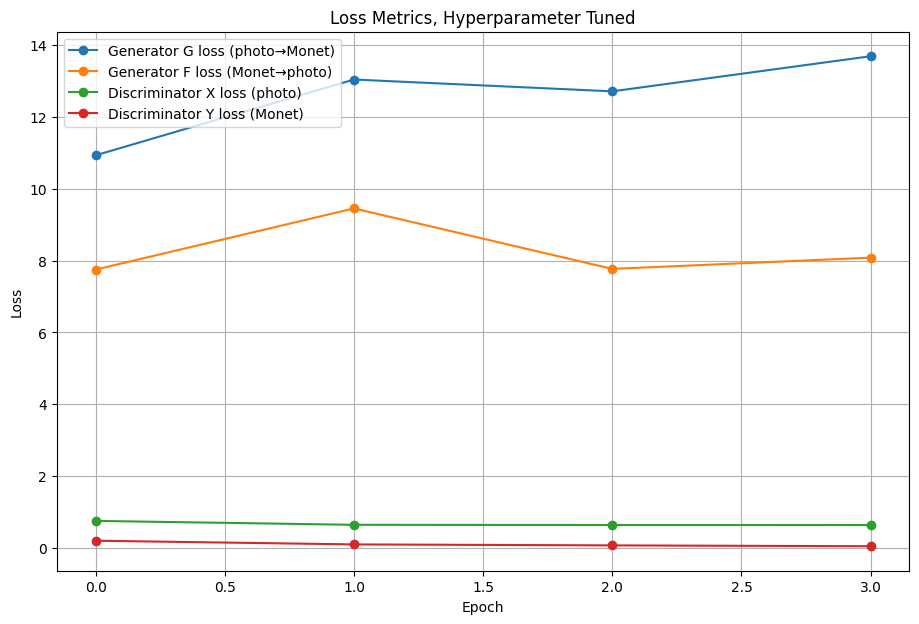

In [62]:
plot_metrics(history, "Loss Metrics, Hyperparameter Tuned")

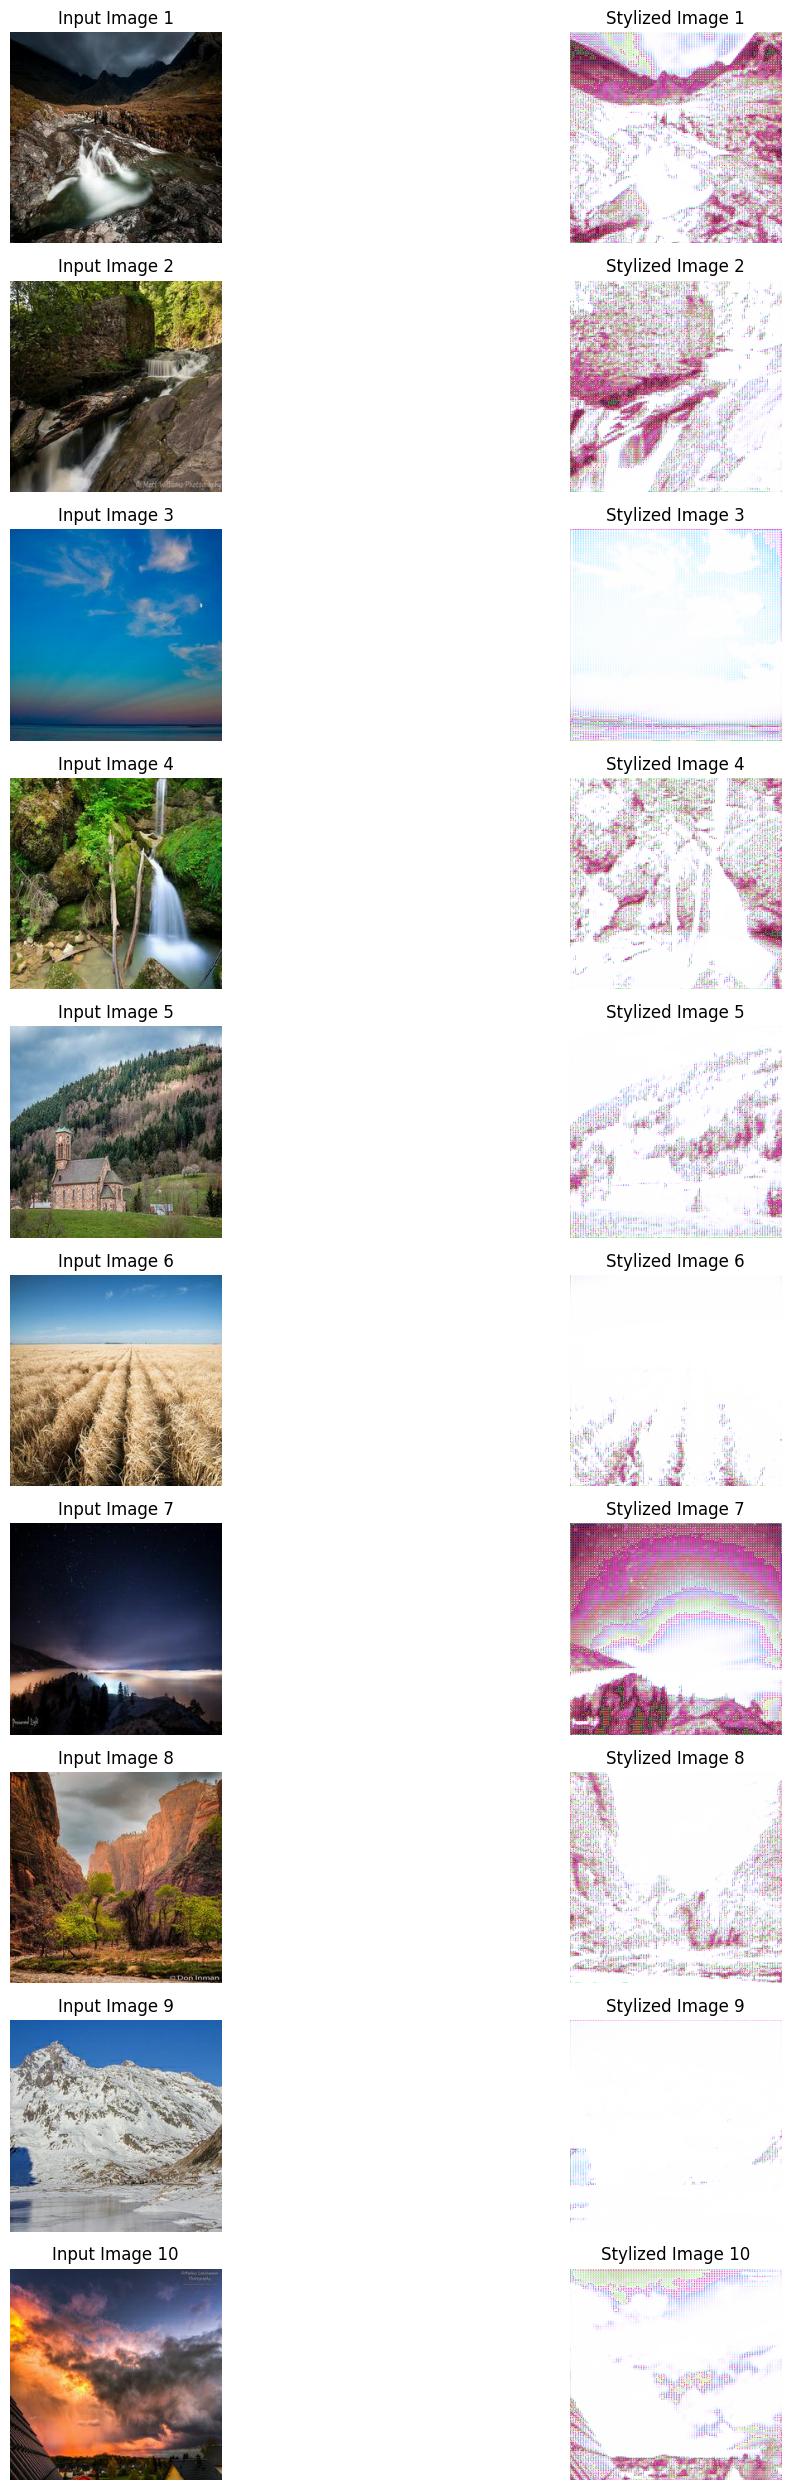

In [63]:
visualize_predictions("/kaggle/input/gan-getting-started/photo_jpg/", generator_g)

In [64]:
#Optimized Hyper parameter tuning

# Adjusting generator learning rate and normalization
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm') 
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm')

# Keep discriminator normalization simpler for sharper detail preservation
discriminator_x = discriminator(norm_type=None, target=False)  
discriminator_y = discriminator(norm_type=None, target=False)

# Instantiate model
model = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)

# Optimized learning rates
model.compile(
    opt_g=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), 
    opt_f=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    opt_dx=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    opt_dy=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=gen_loss,
    disc_loss_fn=disc_loss,
    cycle_loss_fn=lambda real, fake: cycle_loss(real, fake) * 20,  
    identity_loss_fn=identity_loss
)

# Early stopping based on discriminator instead of generator
early_stopping = EarlyStopping(
    monitor='disc_x_loss',  
    patience=4,  
    restore_best_weights=True,
    mode='min',
    verbose=1
)

# Train model
history = model.fit(combined_dataset, epochs=15, callbacks=[early_stopping])

Epoch 1/15
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 54s 26ms/step - disc_x_loss: 0.6486 - disc_y_loss: 0.6561 - gen_f_loss: 31.7605 - gen_g_loss: 31.6849
Epoch 2/15
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - disc_x_loss: 0.6467 - disc_y_loss: 0.6402 - gen_f_loss: 17.7756 - gen_g_loss: 17.7325
Epoch 3/15
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - disc_x_loss: 0.6438 - disc_y_loss: 0.6411 - gen_f_loss: 14.0359 - gen_g_loss: 13.9923
Epoch 4/15
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - disc_x_loss: 0.6420 - disc_y_loss: 0.6398 - gen_f_loss: 12.0063 - gen_g_loss: 11.9580
Epoch 5/15
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - disc_x_loss: 0.6411 - disc_y_loss: 0.6388 - gen_f_loss: 10.6993 - gen_g_loss: 10.6458
Epoch 6/15
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - disc_x_loss: 0.6395 - disc_y_loss: 0.6384 - gen_f_loss: 9.8973 - gen_g_loss: 9.8378
Epoch 7/15
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - disc_x_loss: 0.6378 - disc_y_loss: 0.6385 - gen_f_loss: 9.1946 - gen_g_loss: 9.1

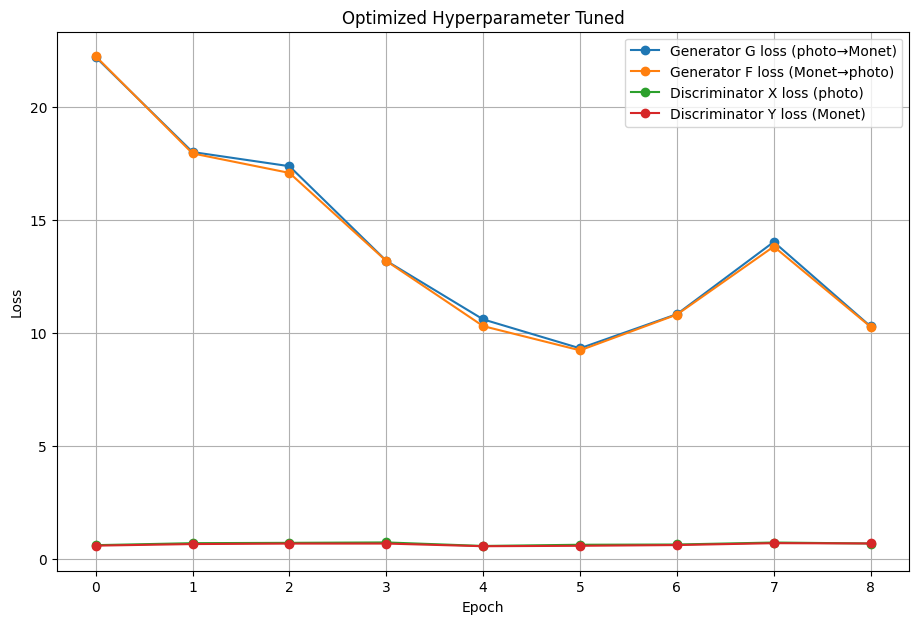

In [65]:
plot_metrics(history, "Optimized Hyperparameter Tuned")

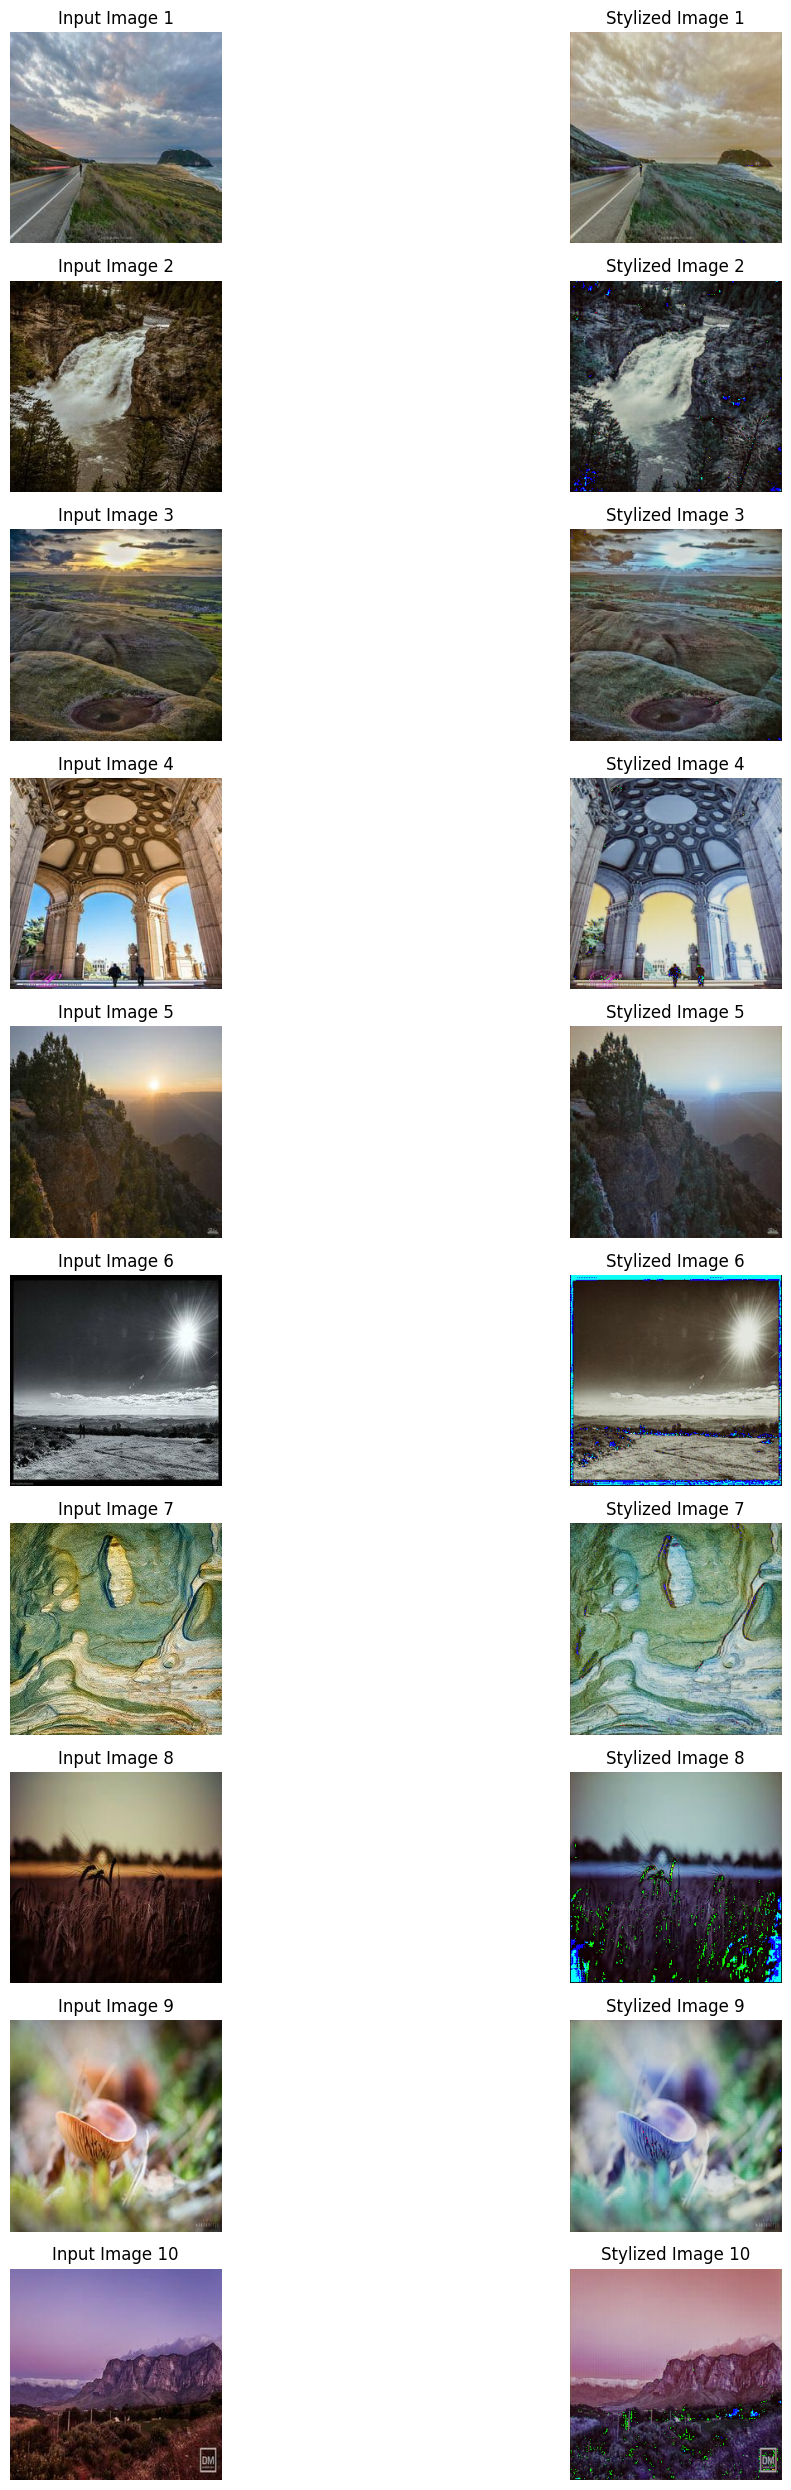

In [66]:
visualize_predictions("/kaggle/input/gan-getting-started/photo_jpg/", generator_g)

In [67]:
# # Create a new directory for the tuned model weights
# new_model_dir = '/kaggle/working/tuned_models/'

# # Ensure the directory exists
# os.makedirs(new_model_dir, exist_ok=True)

# # Save weights for generator_g (with a new name to avoid overwriting)
# generator_g.save_weights(f'{new_model_dir}generator_g_tuned.weights.h5')

# # Save weights for generator_f (with a new name to avoid overwriting)
# generator_f.save_weights(f'{new_model_dir}generator_f_tuned.weights.h5')

# # Save weights for discriminator_x (with a new name to avoid overwriting)
# discriminator_x.save_weights(f'{new_model_dir}discriminator_x_tuned.weights.h5')

# # Save weights for discriminator_y (with a new name to avoid overwriting)
# discriminator_y.save_weights(f'{new_model_dir}discriminator_y_tuned.weights.h5')

# # Save the entire model (architecture + weights) in the new directory
# model.save(f'{new_model_dir}cyclegan_tuned_model.keras')

# # Function to generate Monet images in smaller batches
# def generate_images_in_batches(photo_paths, batch_size=32):
#     fake_monet_images = []
    
#     # Process images in smaller batches
#     for i in range(0, len(photo_paths), batch_size):
#         batch_paths = photo_paths[i:i+batch_size]
        
#         # Load and preprocess the batch of images
#         batch_images = tf.stack([preprocess_image(p) for p in batch_paths])
        
#         # Ensure the batch has the correct shape (batch_size, 256, 256, 3)
#         batch_images = tf.squeeze(batch_images, axis=1)  # Remove the extra dimension
        
#         # Generate Monet images by passing the test images through the generator
#         fake_batch = model.gen_g(batch_images, training=False)
        
#         # Rescale the generated images and store them
#         fake_batch = ((fake_batch + 1.0) * 127.5).numpy().astype(np.uint8)
#         fake_monet_images.extend(fake_batch)
    
#     return fake_monet_images

# # Call the function with the appropriate batch size
# fake_monet_images = generate_images_in_batches(photo_paths, batch_size=32)

# # Create a directory to save generated images
# output_dir = '/kaggle/working/monet_generated_images'
# os.makedirs(output_dir, exist_ok=True)

# # Save each generated Monet image
# for i, img_array in enumerate(fake_monet_images):
#     img = Image.fromarray(img_array)
#     img_name = os.path.basename(photo_paths[i])
#     img.save(os.path.join(output_dir, img_name))

# # Create a DataFrame for submission with the image names
# import pandas as pd

# submission_df = pd.DataFrame({
#     'image_name': [os.path.basename(p) for p in photo_paths]
# })

# # Save the DataFrame as a CSV file (this is usually required for Kaggle submission)
# submission_df.to_csv('/kaggle/working/submission_2.csv', index=False)

# print("Monet-style images and submission file saved in /kaggle/working/")


## Hyperparameter Tuning Conclusion:
* The optimized tuning approach gradually improved CycleGAN’s stability and output quality which reached a better adversarial balance while avoiding common pitfalls like mode collapse and blur unlike the first hyperparameter tuning
* Transitioning from a high learning rate 2e-2 to a more stable 2e-4 prevented excessive generator instability.
* Switching instance normalization to batch normalization improved image sharpness.
* Increasing weight (λ=20) helped retain fine details in transformations by maintaining cycle consistency.
* Shifting early stopping to disc_x_loss allowed better tracking of model equilibrium, preventing generator collapse.


## Observations
* Loss trends indicate smoother convergence while discriminators are neither too weak nor too overpowering.
* Early stopping occurred at optimal epochs which prevented overfitting while ensuring robust results.
* Generated images became sharper and more detailed with the balance between real images and artistic transformation improved.
* Cycle consistency improved with the reconstructing images better preserved original characteristicsat all.

## Conclusion
CycleGAN project has progressed through several tuning stages, each refining stability, image quality, and overall model performance. Here's a summary:

 **Initial Model Performance**:
- The first CycleGAN model successfully generated Monet-style images but suffered from unstable loss trends and blurry outputs due to imbalanced adversarial learning.
- Loss values fluctuated significantly, suggesting that the discriminators were overpowering the generators, leading to mode collapse or weak image transformation.

**Hyperparameter Tuning Approach 1**:
- Adjustments in the learning rate (2e-2 to 2e-4) improved model stability by preventing extreme generator instability.
- Changing early stopping criteria to monitor the discriminator rather than the generator provided a more reliable convergence checkpoint.
- Some images became sharper, but tuning cycle consistency loss remained a challenge, leading to loss divergence after several epochs and finally blurred the images.

**Hyperparameter Tuning Approach 2 (Final Optimized Version)**:
- Further balanced learning rates across generators and discriminators, avoiding adversarial dominance.
- Switching instance normalization to batch normalization significantly improved sharpness and fine details.
- Increasing cycle consistency weighting (λ=20) helped retain key image features, reducing unwanted artifacts.
- Early stopping occurred at optimal epochs, preventing overfitting and ensuring stable convergence.
- Resulting images were noticeably sharper, smoother, and visually appealing, demonstrating improved adversarial balance and regularization.


## Future Work Suggestions:

1. Adaptive Learning Rate Scheduling
- Implement learning rate decay to ensure smooth convergence across later epochs.
- Try warm-up schedules to stabilize generator training at the start.

2. Loss Function Enhancements
- Explore least-squares adversarial loss (LSGAN) or Wasserstein loss (WGAN) for better stability.
- Dynamically adjust cycle loss weight across epochs instead of keeping it fixed.

3. Custom Generator-Discriminator Architectures
- Incorporate dense layers in U-Net to introduce deeper feature encoding.
- Use autoencoder-inspired designs to improve latent space representation and style transfer fidelity.

4. Dataset Augmentation & Expansion
- Increase Monet-style image diversity using style transfer methods or synthetic augmentations.
- Try progressive growing GAN techniques for smoother artistic transformations.

## References

**GAN**:
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://jonathan-hui.medium.com/gan-gan-series-2d279f906e7b
* https://arxiv.org/abs/1406.2661
* https://www.tensorflow.org/tutorials/generative/cyclegan
  
**Hyper Parameter Tuning** :
* https://www.tensorflow.org/tutorials/keras/keras_tuner
* https://arxiv.org/abs/2208.07715
* https://medium.com/@siraj.hatoum/gan-hyperparameter-tuning-with-keras-tuner-81e00ad1d6be